In [1]:
#@title Install Dependencies
!pip install --upgrade git+https://github.com/huggingface/diffusers.git --quiet
!pip install transformers scipy ftfy accelerate --quiet
!pip install "ipywidgets>=7,<8" --quiet
!pip install flask-bootstrap pyngrok --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.4/456.4 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
#@title Setup Diffusion module
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

repo_id = "andite/anything-v4.0" #@param ["CompVis/stable-diffusion-v1-4", "stabilityai/stable-diffusion-2-base", "hakurei/waifu-diffusion", "andite/anything-v4.0"]
pipe = DiffusionPipeline.from_pretrained(
    repo_id, 
    torch_dtype=torch.float16, 
    # revision="fp16"
    )

# pipe.scheduler = DPMSolverMultistepScheduler.from_config(
#     pipe.scheduler.config
#     )
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [3]:
#@title Create server content

def indexFile(public_url):
  return """
<!DOCTYPE html>
<html lang="en">
  <head>
    <title>Text2Image API Preview</title>
    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width" />
    <link
      rel="icon"
      href="https://icons.iconarchive.com/icons/diversity-avatars/avatars/256/robot-01-icon.png"
    />
    <link
      rel="stylesheet"
      href="https://unpkg.com/@picocss/pico@latest/css/pico.min.css"
    />
    <style>
      body {
        max-width: 35rem;
        margin: 0 auto;
        padding: 1em;
      }
      form {
        display: grid;
        grid-template-columns: auto auto;
        grid-gap: 2%;
      }
      img {
        width: 100%;
        padding: 2%;
        border: 1px solid;
      }
      form input[type='submit'] {
        grid-column: span 2;
      }
      footer p {
        text-align: center;
        font-size: smaller;
        margin-bottom: 0.1em;
      }
      .seed,
      .non-genrated {
        text-align: center;
      }
      .genrated {
        display: none;
      }
    </style>
    <script type="module">
      const url = '"""+public_url+"""/api';

      const form = document.querySelector('form');
      const input = (name) => form.querySelector(`input[name="${name}"]`).value;

      const addSeed = (string) => {
        const encoded = new TextEncoder().encode(string);
        const dataview = new DataView(encoded.buffer);
        const seed = dataview.getUint32();
        document.querySelector('.seed code').textContent = seed;
        return seed;
      };

      form.addEventListener('submit', (event) => {
        document.querySelector('.non-genrated').style.display = 'none';
        document.querySelector('.genrated').style.display = 'block';

        const seed = addSeed(input('name') + input('email') + input('dob'));
        const img = document.querySelector('img');
        img.src = url + `?prompt=${input('bio')}&seed=${seed}`;
        event.preventDefault();
      });
    </script>
  </head>
  <body>
    <main>
      <h1>Text2Image API Preview</h1>
      <form>
        <div>
          <label for="name">Name:</label>
          <input
            type="text"
            name="name"
            placeholder="Ex: Aman Varma"
            required
            value="Aman Varma"
          />
        </div>
        <div>
          <label for="email">Email:</label>
          <input
            type="text"
            name="email"
            placeholder="Ex: skotox@altmails.com"
            required
            value="skotox@altmails.com"
          />
        </div>
        <div>
          <label for="dob">Date of Birth:</label>
          <input type="date" name="dob" required value="2003-05-05" />
        </div>
        <div>
          <label for="bio">Bio:</label>
          <input type="text" name="bio" placeholder="Dog Lover" required />
        </div>
        <input type="submit" />
      </form>
      <p class="non-genrated">
        Fill the form and click on <kbd>Submit</kbd> to genrate the image
      </p>
      <div class="genrated">
        <p class="seed">Seed: <code></code></p>
        <img src="" alt="Genrated Image" />
      </div>
    </main>
    <footer>
      <p>
        Made By <strong>Aman Varma</strong>, <strong>Aaman Khan</strong> and
        <strong>Musab Khan</strong>
      </p>
      <p>Project of <strong>Theem College of Engineering</strong></p>
    </footer>
  </body>
</html>
"""

def create_image(prompt, seed):
  generator = torch.Generator(device="cuda").manual_seed(seed)
  return pipe(prompt + "portrait", generator=generator, num_inference_steps=25).images[0]

In [4]:
from pyngrok import ngrok, conf
from flask import Flask, send_file, request
from io import BytesIO
import urllib.parse

app = Flask(__name__)

ngrok_token = "1vRAxOgKbLXCZRMxXCQEjbmpFHq_4CRzVKsCL4r1AAg7DSytn" #@param {type: "string"}
conf.get_default().auth_token = ngrok_token
port = 5000 #@param {type: "number"}
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))
app.config["BASE_URL"] = public_url

def serve_pil_image(pil_img):
    img_io = BytesIO()
    pil_img.save(img_io, 'JPEG', quality=70)
    img_io.seek(0)
    return send_file(img_io, mimetype='image/jpeg')

@app.route('/')
def index():
  return indexFile(public_url)

@app.route('/api')
def api():
  prompt = urllib.parse.unquote(request.args.get('prompt'))
  seed = int(request.args.get('seed'))
  return serve_pil_image(create_image(prompt, seed))

if __name__ == '__main__':
  app.run()

 * ngrok tunnel "http://73fc-34-73-151-156.ngrok.io" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


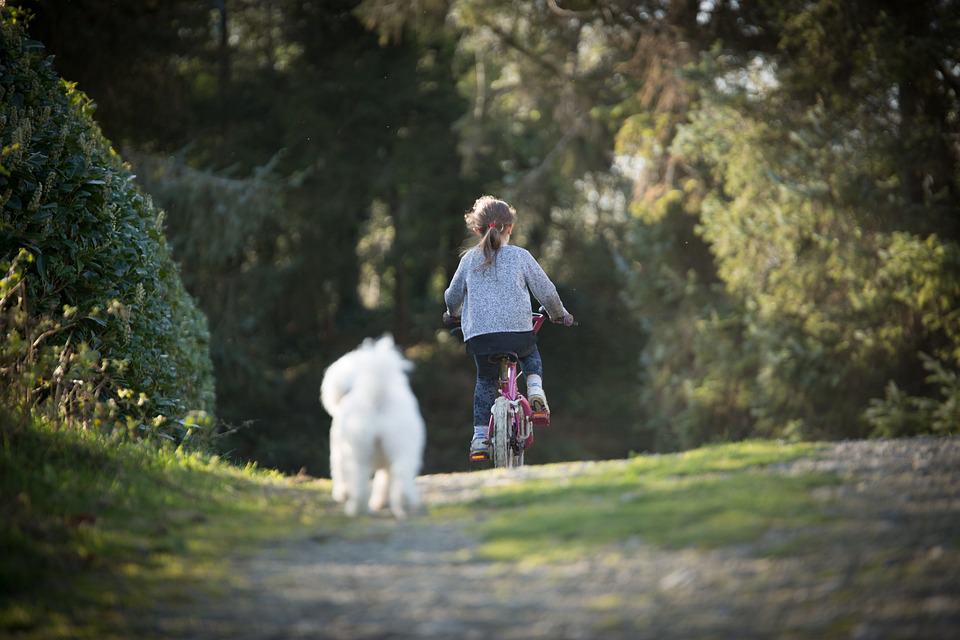

In [ ]:
import requests
from PIL import Image
from io import BytesIO

image_url = "https://cdn.pixabay.com/photo/2020/02/06/09/39/summer-4823612_960_720.jpg"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
image

  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


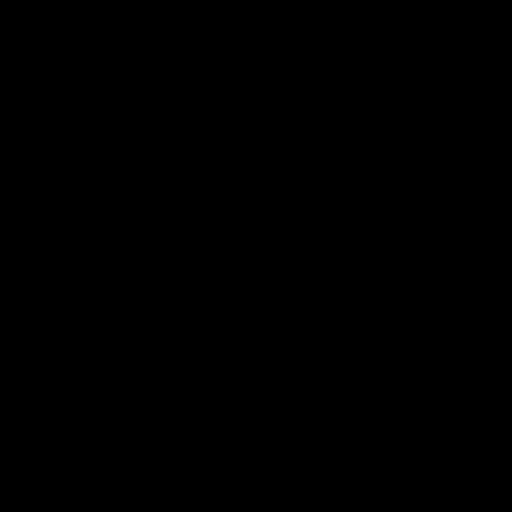

In [5]:
create_image("a boy with beautiful girlfriend", 123)